In [127]:
import pandas as pd
import numpy as np
import json
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Correspondance between 2016 and 2020 FSA

The FSA have evolved since the census in 2016. The main part of the FSA is similar, but some of them have changed. So, we will group them in order to have similar territories for the data from 2016 and the data from 2020.

In [2]:
def process_fsa(fsa, year):
    if year == 2020:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4Y': 'H9P', 'H9P': 'H9P',
                'H5B': 'H2Z',
                'H5A': 'H3A-H3B', 'H4Z': 'H3A-H3B',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T', 'H4T': 'H4R-H4S-H4T'}
    if year == 2016:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T'}
    if fsa in fsas:
        return fsas[fsa]
    else:
        return fsa

# Foursquare

In [3]:
# Export the foursquare dataset
foursquare = pd.read_csv('../data/foursquare/all.csv')

# Drop duplicates
foursquare.drop_duplicates(subset = 'id', inplace=True, ignore_index=True)

# Process the data to group categories
def process_categories(category_name):
    
    # Restaurant and Bar
    restaurant = ['restaurant', 'bar', 'café', 'cafe', 'coffee', 'pizza', 'sandwich', 'breakfast spot', 'ice cream',
                  'frozen yogurt', 'speakeasy', 'nightlife', 'diner', 'lounge', 'joint', 'snack', 'bistro', 'food truck',
                  'brewery', 'strip club', 'pub', 'nightclub', 'food court', 'steakhouse', 'tea room', 'taco', 'castle',
                  'creperie', 'buffet', 'food service', 'bath house', 'poke place', 'soup place', 'club house',
                  'fish & chips', 'burrito', 'poutine', 'noodle', 'brasserie', 'well', 'salad place', 'beer garden']
    for r in restaurant:
        if r in str(category_name).lower() and str(category_name) not in ['Salon / Barbershop', 'Piano Bar', 'Public Art']:
            return 'RestaurantBar'
    
    # Entertainment
    entertainment = ['museum', 'theater', 'entertainment', 'event space', 'art gallery', 'performing', 'public art',
                     'art studio', 'library', 'design', 'music venue', 'comedy', 'photography', 'sculpture',
                     'convention center', 'arcade', 'bowling', 'recreation', 'rock', 'jazz', 'concert', 'auditorium',
                     'water', 'monument', 'lighthouse', 'exhibit', 'planetarium', 'recording studio', 'memorial site',
                     'piano', 'circus', 'zoo', 'massage', 'casino', 'play area']
    for e in entertainment:
        if e in str(category_name).lower() and 'college' not in str(category_name).lower() or str(category_name) == 'Spa':
            return 'EntertainmentCulture'
    
    # Services
#     services = ['store', 'shop', 'service', 'pharmacy', 'bank', 'bakery', 'gas station', 'government', 'bodega',
#                 'salon', 'post', 'rental car', 'veterinarian', 'boutique', 'car wash', 'tattoo', 'butcher', 'real estate',
#                 'auto', 'storage', 'market', 'parking', 'atm', 'lawyer', 'funeral', 'food', 'cleaner', 'embassy',
#                 'driving', 'agency', 'courthouse', 'repair', 'winery', 'grocery', 'animal', 'notary', 'food stand',
#                 'credit union', 'locksmith', 'laundromat', 'general travel']
#     for s in services:
#         if s in str(category_name).lower():
#             return 'Services'
    
    # Sports
    sports = ['pool', 'gym', 'sports', 'field', 'studio', 'court', 'rink', 'golf', 'arena', 'track', 'stadium',
              'skate', 'range', 'dojo', 'curling']
    for s in sports:
        if s in str(category_name).lower():
            return 'Sports'
    
    # Outdoor
    outdoor = ['park', 'outdoor', 'scenic lookout', 'site', 'garden', 'marina', 'boat', 'plaza', 'trail', 'mountain', 'surf',
               'campground', 'lake', 'beach', 'rest area', 'vineyard', 'forest', 'nature', 'cave', 'fishing', 'rafting']
    for o in outdoor:
        if o in str(category_name).lower():
            return 'Outdoor'
    
#     # Medical
#     medical = ['dentist', 'doctor', 'medical', 'hospital', 'assisted living', 'chiropractor', 'mental', 'healer',
#                'emergency', 'therapist', 'laboratory', 'acupuncturist', 'clinic']
#     for m in medical:
#         if m in str(category_name).lower():
#             return 'Medical'
    
#     # Religious
#     religious = ['church', 'synagogue', 'temple', 'spiritual', 'mosque', 'shrine']
#     for r in religious:
#         if r in str(category_name).lower():
#             return 'Religious'
    
    # All other
    if pd.isna(category_name):
        category = 'Other'

    return 'Other'

foursquare['Category'] = foursquare['category_name'].apply(process_categories)
# Process the FSA to make correspondance between 2016 and 2020
foursquare['FSA'] = foursquare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by categories to get the number of venues for each category per FSA
foursquare = foursquare[['FSA', 'id', 'Category']].groupby(['FSA', 'Category']).agg(NbVenue=('id','count')).reset_index()
foursquare.head()

FSA              Category  NbVenue
0  H1A  EntertainmentCulture        3
1  H1A                 Other       67
2  H1A               Outdoor       10
3  H1A         RestaurantBar        7
4  H1A                Sports        9

# STM

In [4]:
# Read the CSV file with the metro stations per FSA
metro_stations = pd.read_csv('../data/metro/metro_stations.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
metro_stations['FSA'] = metro_stations['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of stations per FSA
metro_stations = metro_stations.groupby(['FSA']).agg(MetroStations=('Name', 'count')).reset_index()
metro_stations.head()

FSA  MetroStations
0  H1L              1
1  H1N              4
2  H1V              1
3  H1W              3
4  H2A              1

# Daycare

In [5]:
# Get the data from the CSV file
daycare = pd.read_csv('../data/daycare/liste-des-services-de-garde-07.csv', engine='python')

# Keep only the daycares in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
daycare = daycare[daycare['CODE_POSTAL_COMPO'].apply(mtl_fsa)].reset_index(drop=True)
daycare['FSA'] = daycare['CODE_POSTAL_COMPO'].apply(lambda x: x[0:3])

# Process the FSA to make correspondance between 2016 and 2020
daycare['FSA'] = daycare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of daycares per FSA
daycare = daycare.groupby(['FSA']).agg(Daycare=('ADRESSE','count')).reset_index()
daycare.head()

FSA  Daycare
0  H1A       14
1  H1B       10
2  H1C        8
3  H1E       28
4  H1G       26

# Schools

In [6]:
# Get the data from the CSV files
college = pd.read_csv('../data/schools/ES_Collegial.csv', sep=';')
univ = pd.read_csv('../data/schools/ES_Universitaire.csv', sep=';')
pps_gouv = pd.read_csv('../data/schools/PPS_Gouvernemental.csv', sep=';')
pps_prive = pd.read_csv('../data/schools/PPS_Prive_Installation.csv', sep=';')
pps_public = pd.read_csv('../data/schools/PPS_Public_Ecole.csv', sep=';')
pps_public.rename(columns={'CD_POSTL_GDUNO_ORGNS': 'CD_POSTL_GDUNO'}, inplace=True)

# Keep only the schools in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
college = college[college['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
univ = univ[univ['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_gouv = pps_gouv[pps_gouv['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_prive = pps_prive[pps_prive['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_public = pps_public[pps_public['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)

# Duplicate rows with multiple school levels and separate the name to have one row for one school level
def school_level(school):
    for i in school.index:
        s = school.loc[i, 'ORDRE_ENS'].split('-')
        if len(s) > 1:
            for j in range(1, len(s)):
                m = max(school.index)+1
                school.loc[m] = school.loc[i]
                school.loc[m, 'ORDRE_ENS'] = s[j]
                if school.loc[m, 'ORDRE_ENS'][0] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][1:]
                if school.loc[m, 'ORDRE_ENS'][-1] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][:-1]
            school.loc[i, 'ORDRE_ENS'] = s[0]
            school.loc[i, 'ORDRE_ENS'] = school.loc[i, 'ORDRE_ENS'][:-1]
    school.sort_values(by=['OBJECTID'], inplace=True)
    school.reset_index(drop=True, inplace=True)
    return school
pps_prive = school_level(pps_prive)
pps_public = school_level(pps_public)

# Create a dataframe containing all the schools with the FSA and the school level
schools = pd.concat([college[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     univ[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_gouv[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_prive[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_public[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']]])
schools['CD_POSTL_GDUNO'] = schools['CD_POSTL_GDUNO'].apply(lambda x: x[0:3])
schools.rename(columns={'OBJECTID': 'SchoolId', 'CD_POSTL_GDUNO': 'FSA', 'ORDRE_ENS': 'Level'}, inplace=True)

# Classify the school level into three categories: PPS (Preschool, Primary school and Secondary school),
# Post-secondary and Professional Formation - Adult Education
def classify_school_levels(level):
    if level in ['Préscolaire', 'Primaire', 'Secondaire']:
        return 'PPS'
    if level in ['Collégial', 'Universitaire']:
        return 'PostSecondary'
    if level in ['Éducation aux adultes', 'Formation professionnelle']:
        return 'ProfessionalFormation-AdultEducation'
schools['SchoolType'] = schools['Level'].apply(classify_school_levels)
schools.sort_values(by=['FSA'], inplace=True)

# Process the FSA to make correspondance between 2016 and 2020
schools['FSA'] = schools['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of schools (for each category) per FSA
schools = schools.groupby(['FSA', 'SchoolType']).agg(NbSchool=('SchoolId','count')).reset_index()
schools.head()

FSA                            SchoolType  NbSchool
0  H1A                                   PPS        23
1  H1B                                   PPS        16
2  H1B  ProfessionalFormation-AdultEducation         6
3  H1C                                   PPS        14
4  H1E                                   PPS        15

# Walkscore

Let's see all the available and not available walkscores, transitscores and bikescores on the map.

In [7]:
# Data for Montreal
latitude = 45.535433
longitude = -73.636493
mtl_geo_json = "../data/maps/mtl_fsa_map.geojson"
mtl_grp_geo_json = "../data/maps/mtl_fsa_grouped_map.geojson"

# Get the walkscore data
ws = pd.read_csv('../data/walkscore/walkscore.csv', index_col=0)

# Choose the score to visualize
score = 'Walkscore' # 'Walkscore' or 'Transitscore' or 'Bikescore'

# Built the map
nan_ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(nan_ws_map)
for lat, lng, score in zip(ws['Latitude'], ws['Longitude'], ws[score]):
    label = folium.Popup(str(score), parse_html=True)
    if np.isnan(score):
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='red',
            parse_html=False).add_to(nan_ws_map)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='blue',
            parse_html=False).add_to(nan_ws_map)
nan_ws_map

The available walkscores and bikescores can be processed but the transitscores are not relevant because they are too concentrated on a single geographic area.

In [8]:
# Process the FSA to make correspondance between 2016 and 2020
ws['FSA'] = ws['FSA'].apply(lambda x: process_fsa(x, 2016))
# Get the mean score for each FSA
walkscore = ws.groupby('FSA', as_index=False).mean()
# Drop the transitscore because it is not relevant
walkscore.drop(columns='Transitscore', inplace=True)
walkscore.rename(columns={'Walkscore': 'WalkscoreValue',
                          'Bikescore': 'BikescoreValue'}, inplace=True)

# Get the description associated with the score
def score_description(score, score_type):
    description = {'Walkscore': ['Car-dependent+', 'Car-dependent', 'SomewhatWalkable',
                                  'VeryWalkable', 'WalkersParadise'],
                    'Bikescore': ['SomewhatBikeable', 'SomewhatBikeable', 'Bikeable',
                                  'VeryBikeable', 'BikersParadise']}
    if score < 25:
        return description[score_type][0]
    if score >= 25 and score < 50:
        return description[score_type][1]
    if score >= 50 and score < 70:
        return description[score_type][2]
    if score >= 70 and score < 90:
        return description[score_type][3]
    if score >= 90 and score <= 100:
        return description[score_type][4]

score_types = ['Walkscore', 'Bikescore']
for score_type in score_types:
    walkscore[score_type] = walkscore[score_type + 'Value'].apply(lambda x: score_description(x, score_type))
walkscore.head()

FSA   Latitude  Longitude  WalkscoreValue  BikescoreValue       Walkscore  \
0  H1A  45.670741 -73.505878       19.733766       54.967532  Car-dependent+   
1  H1B  45.635377 -73.523538       15.466165       47.318182  Car-dependent+   
2  H1C  45.669124 -73.534936        3.850877       47.157895  Car-dependent+   
3  H1E  45.638857 -73.583131       31.719298       54.719298   Car-dependent   
4  H1G  45.612047 -73.620212       49.437500       60.137500   Car-dependent   

          Bikescore  
0          Bikeable  
1  SomewhatBikeable  
2  SomewhatBikeable  
3          Bikeable  
4          Bikeable

Let's see the choropleth map of Montreal for the walkscores and bikescores:

In [9]:
score = 'WalkscoreValue' # 'WalkscoreValue' or 'BikescoreValue'
bins = {'WalkscoreValue': [0, 25, 50, 70, 90, 100],
        'BikescoreValue': [0, 50, 70, 90, 100]}

ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(ws_map)
label = folium.Popup(score, parse_html=True)
folium.Choropleth(
    geo_data=mtl_grp_geo_json,
    data=walkscore,
    columns=['FSA', score],
    key_on='feature.properties.FSAGROUP',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    bins=bins[score],
    legend_name=score,
    popup=label
).add_to(ws_map)

ws_map

Walkscore:
- 0-25: Car-dependent *(almost all errands require a car)*
- 25-50: Car-dependent *(most errands require a car)*
- 50-70: Somewhat walkable *(some errands can be accomplished on foot)*
- 70-90: Very walkable *(most errands can be accomplished on foot)*
- 90-100: Walker's paradise *(daily errands do not require a car)*

Bikescore:
- 0-50: Somewhat bikeable *(minimal bike infrastructure)*
- 50-70: Bikeable *(some bike infrastructure)*
- 70-90: Very bikeable *(biking is convenient for most trips)*
- 90-100: Biker's paradise *(daily errands can be accomplished on a bike)*

# Creating the master dataframes

In [77]:
# Get the average of a column, ponderated by another
def ponderated_average(df, df_pond, field):
    df = df.join(df_pond.set_index('FSA'), on='FSA')
    d1 = df.drop_duplicates(subset=['FSA'], keep=('first'))
    d2 = df.drop_duplicates(subset=['FSA'], keep=('last'))
    df = pd.concat([d1,d2]).drop_duplicates()
    df['Product'] = df[field] * df['Ponderator']
    df = df.groupby('FSA', as_index=False).sum()
    df[field] = df['Product'] / df['Ponderator']
    return df[['FSA', field]]

## Environment dataframe

In [118]:
# Get the FSA with their areas to create the master dataframe for the FSA environment
df_env = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_env['FSA'] = df_env['FSA'].apply(lambda x: process_fsa(x, 2020))
df_env = df_env.groupby('FSA', as_index=False).sum()

# Add the walkscores and bikescores to the dataframe
df_env = df_env.join(walkscore[['FSA', 'Walkscore', 'Bikescore']].set_index('FSA'), on='FSA')
# We can't cluster categorical features so let's turn them into numerical ones
df_env['Walkscore'] = df_env['Walkscore'].replace({'Car-dependent+': 0,
                                                   'Car-dependent': 1,
                                                   'SomewhatWalkable': 2,
                                                   'VeryWalkable': 3,
                                                   'WalkersParadise': 4})
df_env['Bikescore'] = df_env['Bikescore'].replace({'SomewhatBikeable': 0,
                                                   'SomewhatBikeable': 1,
                                                   'Bikeable': 2,
                                                   'VeryBikeable': 3,
                                                   'BikersParadise': 4})

# Add the foursquare venues
categories = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor']
for category in categories:
    df_temp = foursquare[foursquare['Category'] == category][['FSA', 'NbVenue']]
    df_env = df_env.join(df_temp.rename(columns={'NbVenue': category}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[category] = df_env[category] / df_env['Area(km2)']

# Add the metro stations
df_env = df_env.join(metro_stations.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['MetroStations'] = df_env['MetroStations'] / df_env['Area(km2)']

# Add the daycares
df_env = df_env.join(daycare.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['Daycare'] = df_env['Daycare'] / df_env['Area(km2)']

# Add the schools
school_types = ['PPS', 'PostSecondary']
for school_type in school_types:
    df_temp = schools[schools['SchoolType'] == school_type][['FSA', 'NbSchool']]
    df_env = df_env.join(df_temp.rename(columns={'NbSchool': school_type}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[school_type] = df_env[school_type] / df_env['Area(km2)']

# Fill the Nan values with zero
df_env.fillna(0, inplace=True)


# # Converting numerical values into categorical ones for the models
# def num_to_cat(value, category):
#     if category in ['MetroStations', 'PostSecondary']:
#         if value == 0:
#             return 'None'
#         elif value > 0 and value < 1:
#             return 'SomeInTheFSA'
#         else:
#             return 'SomeClose'
#     else:
#         thresholds = {'RestaurantBar': [[0, 2, 5, 10], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'EntertainmentCulture': [[0, 1, 3, 6], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'Sports': [[0, 1, 2], ['NoneOrFew', 'Some', 'Choice']],
#                       'Outdoor': [[0, 1, 2], ['NoneOrFew', 'Some', 'Paradise']],
#                       'Daycare': [[0, 1, 3, 6], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'PPS': [[0, 1, 4], ['NoneOrFew', 'Some', 'Choice']]}
#         for i in range(len(thresholds[category][0])):
#             if i + 1 < len(thresholds[category][0]):
#                 if value >= thresholds[category][0][i] and value < thresholds[category][0][i+1]:
#                     return thresholds[category][1][i]
#             else:
#                 if value >= thresholds[category][0][i]:
#                     return thresholds[category][1][i]

# categories = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor', 'MetroStations', 'Daycare', 'PPS', 'PostSecondary']
# for category in categories:
#     df_env[category] = df_env[category].apply(lambda x: num_to_cat(x, category))

df_env.drop(columns=['Area(km2)'], inplace=True)
df_env.round(2).head()

FSA  Walkscore  Bikescore  RestaurantBar  EntertainmentCulture  Sports  \
0  H1A          0          2           0.46                  0.20    0.59   
1  H1B          0          1           1.87                  0.67    0.07   
2  H1C          0          1           0.71                  0.36    0.18   
3  H1E          1          2           2.70                  0.36    0.45   
4  H1G          1          2           2.41                  0.51    0.38   

   Outdoor  MetroStations  Daycare   PPS  PostSecondary  
0     0.66            0.0     0.92  1.51           0.00  
1     0.45            0.0     0.75  1.19           0.00  
2     0.54            0.0     0.71  1.25           0.00  
3     0.18            0.0     2.52  1.35           0.00  
4     0.13            0.0     3.29  3.16           0.38

## Population dataframe

In [136]:
# Get the FSA with their areas to create the master dataframe for the FSA population
df_pop = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_pop['FSA'] = df_pop['FSA'].apply(lambda x: process_fsa(x, 2020))
df_pop = df_pop.groupby('FSA', as_index=False).sum()

# Get the census data
census = pd.read_csv('../data/census/census_20200808_1501.csv', index_col=0)
for fsa in ['H4T', 'H4Y', 'H4Z', 'H5A', 'H5B']:
    census = census[census['FSA'] != fsa]
# Process the FSA to make correspondance between 2016 and 2020
census['FSA'] = census['FSA'].apply(lambda x: process_fsa(x, 2016))

# Get the fields we are interested in for the population dataframe
# Population
df_temp = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].groupby('FSA', as_index=False).sum()
df_pop = df_pop.join(df_temp.rename(columns={'CategoryValue': 'Population'}).set_index('FSA'), on='FSA')
# Get the density of population instead of the number for a better comparison
df_pop['Population'] = df_pop['Population'] / df_pop['Area(km2)']

# Age, Income
fields = {'Age': '1.2.4',
          'Income': '4.1.1.1.1'}
for field in fields:
    # for grouped FSA: take the average, ponderated by the population of the FSA
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_pond = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Ponderator'})
    df_temp = ponderated_average(df_temp, df_pond, field)
    df_pop = df_pop.join(df_temp.set_index('FSA'), on='FSA')

# Types of families
df_temp = census[census['TypeHierId'] == '2.3.4.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'CouplesNoChildren'}).groupby('FSA', as_index=False).sum()
fields = {'CouplesWithChildren': ['2.3.4.2', 'TypeValue'],
          'LoneWithChildren': ['2.3.5.1', 'CategoryValue'],
          'OnePerson': ['2.4.1.3.1', 'TypeValue'],
          'MultipleNoFamily': ['2.4.1.3.2', 'TypeValue']}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field][0]][['FSA', fields[field][1]]].rename(
        columns={fields[field][1]: field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['FamiliesWithChildren'] = df_temp['CouplesWithChildren'] + df_temp['LoneWithChildren']
columns = ['CouplesNoChildren', 'FamiliesWithChildren', 'OnePerson', 'MultipleNoFamily']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_pop = df_pop.join(df_temp[['FSA',
                              'CouplesNoChildren(%)',
                              'FamiliesWithChildren(%)',
                              'OnePerson(%)',
                              'MultipleNoFamily(%)']].set_index('FSA'), on='FSA')

df_pop.drop(columns=['Area(km2)'], inplace=True)
df_pop.round(2).head()

FSA  Population   Age   Income  CouplesNoChildren(%)  \
0  H1A     2139.21  46.3  35303.0                 25.93   
1  H1B     1504.48  44.0  31150.0                 23.20   
2  H1C     1310.54  37.1  36786.0                 21.00   
3  H1E     3821.62  43.5  28969.0                 22.51   
4  H1G     6146.33  41.4  23258.0                 17.08   

   FamiliesWithChildren(%)  OnePerson(%)  MultipleNoFamily(%)  
0                    38.95         31.47                 3.65  
1                    36.57         35.92                 4.31  
2                    62.28         14.94                 1.78  
3                    50.07         25.17                 2.24  
4                    44.48         33.56                 4.88

## Housing dataframe

In [104]:
# Get the FSA with their areas to create the master dataframe for the FSA housing
df_hous = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_hous['FSA'] = df_hous['FSA'].apply(lambda x: process_fsa(x, 2020))
df_hous = df_hous.groupby('FSA', as_index=False).sum()

# Get the census data
census = pd.read_csv('../data/census/census_20200808_1501.csv', index_col=0)
for fsa in ['H4T', 'H4Y', 'H4Z', 'H5A', 'H5B']:
    census = census[census['FSA'] != fsa]
# Process the FSA to make correspondance between 2016 and 2020
census['FSA'] = census['FSA'].apply(lambda x: process_fsa(x, 2016))

# Get the fields we are interested in for the population dataframe
# Number of dwellings
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].groupby(
    'FSA', as_index=False).sum()
df_hous = df_hous.join(df_temp.rename(columns={'CategoryValue': 'NbDwellings'}).set_index('FSA'), on='FSA')
# Get the density of dwellings instead of the number for better comparison
df_hous['NbDwellings'] = df_hous['NbDwellings'] / df_hous['Area(km2)']

# Value and average number of rooms
fields = {'Value($)': '9.1.13.5',
          'NbRooms': '9.1.5'}
for field in fields:
    # for grouped FSA: take the average, ponderated by the number of dwellings of the FSA
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_pond = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Ponderator'})
    df_temp = ponderated_average(df_temp, df_pond, field)
    df_hous = df_hous.join(df_temp.set_index('FSA'), on='FSA')

# Tenure
df_temp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'Rental'}).groupby('FSA', as_index=False).sum()
# Get the pourcentage
df_tmp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'CategoryValue']].rename(
    columns={'CategoryValue': 'Total'}).groupby('FSA', as_index=False).sum()
df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Rental'] = (df_temp['Rental'] / df_temp['Total']) * 100
df_hous = df_hous.join(df_temp[['FSA', 'Rental']].rename(
    columns={'Rental': 'Rental(%)'}).set_index('FSA'), on='FSA')

# Type
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'DetachedHouse'}).groupby('FSA', as_index=False).sum()
fields = {'Apartment5more': '2.1.1.2',
          'SemiDetachedHouse': '2.1.1.3.1',
          'RowHouse': '2.1.1.3.2',
          'ApartmentInDuplex': '2.1.1.3.3',
          'Apartment5less': '2.1.1.3.4',
          'OtherSingleAttachedHouse': '2.1.1.3.5'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Apartment'] = df_temp['Apartment5more'] + df_temp['Apartment5less'] + df_temp['ApartmentInDuplex']
df_temp['AttachedHouse'] = df_temp['SemiDetachedHouse'] + df_temp['RowHouse'] + df_temp['OtherSingleAttachedHouse']
columns = ['DetachedHouse', 'AttachedHouse', 'Apartment']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp[['FSA',
                                'DetachedHouse(%)',
                                'AttachedHouse(%)',
                                'Apartment(%)']].set_index('FSA'), on='FSA')

# Period of construction
df_temp = census[census['TypeHierId'] == '9.1.8.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': '1960OrBefore'}).groupby('FSA', as_index=False).sum()
fields = {'1961-1980': '9.1.8.2',
          '1981-1990': '9.1.8.3',
          '1991-2000': '9.1.8.4',
          '2001-2005': '9.1.8.5',
          '2006-2010': '9.1.8.6',
          '2011-2016': '9.1.8.7'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Recent'] = df_temp['2011-2016'] + df_temp['2006-2010']
df_temp['Aging'] = df_temp['1991-2000'] + df_temp['2001-2005']
df_temp['Old'] = df_temp['1960OrBefore'] + df_temp['1961-1980'] + df_temp['1981-1990']
columns = ['Recent', 'Aging', 'Old']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp[['FSA',
                                'Recent(%)',
                                'Aging(%)',
                                'Old(%)']].set_index('FSA'), on='FSA')


df_hous.drop(columns=['Area(km2)'], inplace=True)
df_hous.round(2).head()

FSA  NbDwellings  Value($)  NbRooms  Rental(%)  DetachedHouse(%)  \
0  H1A       909.87  259561.0      5.5      37.57             24.80   
1  H1B       674.63  250531.0      5.2      50.77             21.57   
2  H1C       418.30  317604.0      6.4      15.26             39.38   
3  H1E      1481.08  331623.0      5.7      35.03             24.79   
4  H1G      2488.61  330116.0      4.8      70.72              7.04   

   AttachedHouse(%)  Apartment(%)  Recent(%)  Aging(%)  Old(%)  
0             21.19         54.01       9.23     20.13   70.64  
1             13.38         65.04       3.81      5.85   90.34  
2             39.17         21.45      26.09     35.46   38.45  
3             26.71         48.49       7.09     18.83   74.08  
4              7.12         85.84       2.54      3.94   93.52

# Tests for clustering

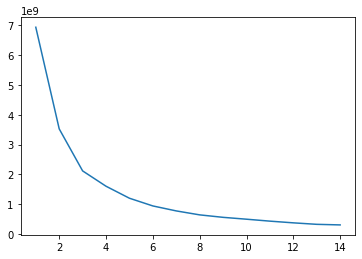

In [141]:
K = range(1, 15)
inertias = []
for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_pop.set_index('FSA'))
    inertias.append(kmeans.inertia_)
plt.plot(K, inertias, '-')

In [137]:
kmean = KMeans(n_clusters=3).fit(df_pop.set_index('FSA'))
df_pop.insert(1, 'Cluster', kmeans.labels_)
kmean.labels_

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2, 2, 0,
       0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1])

In [140]:
df_pop[df_pop['Cluster'] == 2]

FSA  Cluster   Population       Age        Income  \
1       H1B        2  1504.477612  44.00000  31150.000000   
6       H1J        2  1227.142857  46.40000  32367.000000   
7       H1K        2  5616.290323  39.40000  32530.000000   
8       H1L        2  4462.400000  42.80000  30566.000000   
9       H1M        2  5945.524504  49.20000  32227.000000   
22      H2C        2  6998.128042  43.90000  34344.000000   
29      H2M        2  5520.604803  39.70000  35049.000000   
47      H3L        2  5379.562044  39.90000  32076.000000   
56      H3X        2  6667.341040  40.40000  31931.000000   
61      H4C        2  4381.294964  34.30000  30660.000000   
64      H4H        2  6159.846547  41.20000  34161.000000   
73      H4W        2  4340.701754  44.70000  30990.000000   
76      H8P        2  5188.756856  45.90000  31879.000000   
78  H8S-H8T        2  2490.344302  42.25484  32758.198378   
80      H8Z        2  3384.151786  42.60000  31018.000000   
81      H9A        2  3481.473264  41.10000  32811.000000   
85      H9G        2  3758.662467  44.60000  33346.000000   
86      H9H        2  2827.666667  44.00000  32530.000000   
88      H9P        2   254.870130  42.70000  33625.000000   

    CouplesNoChildren(%)  FamiliesWithChildren(%)  OnePerson(%)  \
1              23.198690                36.572052     35.917031   
6              23.541667                35.000000     38.333333   
7              21.157895                44.701754     31.017544   
8              20.981179                32.705955     41.561247   
9              24.875445                29.964413     41.387900   
22             19.243986                31.328751     44.902635   
29             21.800680                30.634202     42.808607   
47             18.394471                32.642212     45.029240   
56             20.732311                37.902029     36.368135   
61             21.417069                19.806763     48.577563   
64             22.357499                32.927504     39.014942   
73             24.772036                41.236069     32.066869   
76             21.004346                35.490101     39.690971   
78             19.699120                36.389441     40.051093   
80             23.672759                49.695387     24.543081   
81             22.955390                58.085502     17.565056   
85             25.279450                51.848667     21.238177   
86             23.271414                49.690402     24.767802   
88             25.324675                48.376623     22.727273   

    MultipleNoFamily(%)  
1              4.312227  
6              3.125000  
7              3.122807  
8              4.751620  
9              3.772242  
22             4.524628  
29             4.756512  
47             3.934078  
56             4.997526  
61            10.198604  
64             5.700055  
73             1.925025  
76             3.814582  
78             3.860346  
80             2.088773  
81             1.394052  
85             1.633706  
86             2.270382  
88             3.571429